Model architecture

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class CnnAudioNet(nn.Module):
    def __init__(self,numClasses):
        super(CnnAudioNet,self).__init__()
        self.num_classes = numClasses
        self.fc_features = 64
        self.C1 = nn.Conv2d(2,32,3,padding=1)
        self.C11 = nn.Conv2d(32,32,3,padding=1)
        self.C2 = nn.Conv2d(32,64,3,padding=1)
        self.C22 = nn.Conv2d(64,64,3,padding=1)
        self.C3 = nn.Conv2d(64,128,3,padding=1)
        self.C33 = nn.Conv2d(128,128,3,padding=1)
        
        self.BN1 = nn.BatchNorm2d(32)
        self.BN11 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN22 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN33 = nn.BatchNorm2d(128)
        self.BNFC = nn.BatchNorm1d(self.fc_features)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.maxpool2 = nn.MaxPool2d((2,2),(2,2))
        self.softmax = nn.Softmax(dim=1)
        
        
        self.fc1 = nn.Linear(64*63*63,self.fc_features)
        self.fc2 = nn.Linear(self.fc_features + 1,self.num_classes) 
        self.dropout = nn.Dropout(0.75)
        
    def forward(self,x,timestamp):
        # add sequence of convolutional and max pooling layers
        x = self.maxpool1(F.relu(self.BN1(self.C1(x))))
        #x = self.maxpool1(F.relu(self.BN11(self.C11(x))))
        x = self.maxpool2(F.relu(self.BN2(self.C2(x))))
        #x = self.maxpool1(F.relu(self.BN22(self.C22(x))))
        #x = self.maxpool1(F.relu(self.BN3(self.C3(x))))
        #x = self.maxpool1(F.relu(self.BN33(self.C33(x))))
        # flatten image input
        x = x.view(-1,64*63*63)
        x =  self.BNFC(self.fc1(x))
        x = self.dropout(x)
        x = torch.cat((x, timestamp/240), 1) #normalize timestamp
        x = self.fc2(x)
        #x = self.softmax(x) #already included in CrossEntropyLoss
        return x
        

Utility functions

In [2]:
import os
import matplotlib
import pylab
import librosa
import numpy as np
#!pip install soundfile
#!pip install torchaudio
import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

#from google.colab import drive
#drive.mount('/content/gdrive')

def plotData(S, sr=44100, hop_length=512):
  S_DB = librosa.power_to_db(S, ref=np.max)
  librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
  plt.colorbar(format='%+2.0f dB');

def saveDataAsImage(S, save_path):
  pylab.axis('off') # no axis
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
  pylab.close()


#!apt-get install sox libsox-dev libsox-fmt-all
#!pip install git+git://github.com/pytorch/audio
from IPython.display import Audio
import torchaudio

def loadRec(wavPath):
  sound, sample_rate = torchaudio.load(wavPath)
  print("sample_rate", sample_rate)
  return Audio(data=sound[0,:],rate=sample_rate) # load a local WAV file

def saveModel(model, model_name, path):
  path = F"{path}/{model_name}.pt"
  torch.save(model.state_dict(), path)

def loadModel(model, model_name, path):
    path = F"{path}/{model_name}.pt"
    model.load_state_dict(torch.load(path))
    return model

@torch.no_grad()
def calculateTestLoss(model, criterion, test_generator):
    model.eval()
    test_loss = 0.
    for dataBatch,target,timestamp in test_generator:
        dataBatch, target, timestamp = dataBatch.float().cuda(), target.cuda(), timestamp.unsqueeze(1).cuda()
        output = model(dataBatch, timestamp)
        loss = criterion(output,torch.max(target.long(), 1)[1])
        test_loss += loss.item()*dataBatch.size(0)

    return test_loss/len(test_generator)

Dataset

In [3]:
from scipy.io import wavfile
from librosa.feature import mfcc
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
from torch.utils import data
from torchvision import datasets, models, transforms

class Dataset(data.Dataset):
    def __init__(self, fileNames, labels, dataPath, numClasses):
        'Initialization'

        self.labels = labels
        self.file_names = fileNames
        self.data_path = dataPath
        self.num_classes = numClasses
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_names)

    def __getitem__(self, index):
        'Generates one sample of data'
        file_name = self.file_names[index]
        label = self.labels[index]
        file = os.path.join(self.data_path, str(label), str(file_name))
        Im = torch.load(file)
        label_out = np.zeros(self.num_classes)
        label_out[label-2] = 1
        label_out = torch.from_numpy(label_out).float()
        timestamp = file_name.split("_", 1)[1]
        timestamp = int(timestamp.split(".", 1)[0])/1000
        timestamp = torch.tensor(timestamp, dtype=torch.float32)
        #print(timestamp, Im.shape, label)

        return Im, label_out,timestamp

In [4]:
import torch.optim as optim
train_on_gpu=torch.cuda.is_available()
num_classes = 10
model = CnnAudioNet(num_classes)
model_name= "HPSSCnnAudioNet"
if(train_on_gpu): 
  model.cuda()
print(model)
# specify loss function (MSE)
#pos_weight = torch.ones([num_classes]).cuda() * num_classes
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)   
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(params=model.parameters(), lr=0.001)# specify optimizer

CnnAudioNet(
  (C1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C33): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN22): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN33): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Load dataset

In [5]:
import os
import pandas as pd
import random
random.seed(1)

path = "/media/kfir/wiseData/Project/Dataset"
test_path = "/media/kfir/wiseData/Project/Testset"
#Load train data
labels = pd.read_csv(os.path.join(path, "labels.csv"))
n_samples = len(labels)
train_len = int(n_samples * 0.9)
valid_len = n_samples - train_len
test_len = n_samples - train_len - valid_len
total_list = list(range(n_samples))
train_list = random.sample(total_list, train_len)
total_list = list(set(total_list)^set(train_list))
valid_list = random.sample(total_list, valid_len)

test_labels = pd.read_csv(os.path.join(test_path, "labels.csv"))
test_len = len(test_labels)
test_list=list(range(test_len))
test_data = test_labels.iloc[test_list]

train_data = labels.iloc[train_list]
valid_data = labels.iloc[valid_list]
test_data = test_labels.iloc[test_list]

path = os.path.join(path, "HPSS")
test_path = os.path.join(test_path, "HPSS")

training_set = Dataset(train_data["filename"].tolist(), train_data["label"].tolist(), path, num_classes)
batch_size = 32
train_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(training_set, **train_params)
#Load validation data
valid_set = Dataset(valid_data["filename"].tolist(), valid_data["label"].tolist(), path, num_classes)
batch_size = 32
valid_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
valid_generator = data.DataLoader(valid_set, **valid_params)
#Load Test data
test_set = Dataset(test_data["filename"].tolist(), test_data["label"].tolist(), test_path, num_classes)
batch_size = 32
test_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
test_generator = data.DataLoader(test_set, **test_params)

print("Training set contains " + str(train_len) + " samples")
print("Validation set contains " + str(valid_len) + " samples")
print("Test set contains " + str(test_len) + " samples")

Training set contains 40217 samples
Validation set contains 4469 samples
Test set contains 10785 samples


Training

In [7]:
import time
#!pip install tqdm
from tqdm.auto import tqdm

try:
    epoch_num = 20
    model = loadModel(model, model_name + "_" + str(epoch_num),"/media/kfir/wiseData/Project/Models/HPSS/epochs3/")
    print("Starting from epoch", epoch_num+1)
except:
    epoch_num = 0
    print("no saved model, start from the beginning...")

start_time = time.time()
#Warnings.filterwarnings('ignore')

# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss
print("Start training:")
idx = 0 
for epoch in range(epoch_num+1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    TotMSE = 0 
    TotEl = 0
    
    ###################
    # train the model #
    ###################
    model.train()

    for batch_idx, (dataBatch, target, timestamp) in tqdm(enumerate(training_generator), total=len(training_generator), leave=True):
        #print("dataBatch.shape", dataBatch.shape)
        
        idx+=1

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            dataBatch, target, timestamp = dataBatch.cuda(), target.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()

        #print(dataBatch.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        #print("dataBatch.shape", dataBatch.shape)
        output = model(dataBatch,timestamp)
        # calculate the batch loss
        #loss = criterion(output, torch.squeeze(torch.argmax(target,dim=-1)))
        loss = criterion(output,torch.max(target.long(), 1)[1])
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*dataBatch.size(0)
        
    train_loss = train_loss / len(training_generator)
    valid_loss = calculateTestLoss(model, criterion, valid_generator)
    test_loss = calculateTestLoss(model, criterion, test_generator)
    print('Epoch: {} \tTrain Loss: {:.6f}\t Validation Loss: {:.6f}\t Test Loss: {:6f}'.format(epoch, train_loss, valid_loss, test_loss))

    saveModel(model,model_name + "_" + str(epoch),"/media/kfir/wiseData/Project/Models/HPSS/epochs3/")


no saved model, start from the beginning...
Start training:



Epoch: 1 	Train Loss: 25.858587	 Validation Loss: 38.428146	 Test Loss: 50.272396



Epoch: 2 	Train Loss: 19.408091	 Validation Loss: 63.246013	 Test Loss: 80.992877



Epoch: 3 	Train Loss: 15.568010	 Validation Loss: 52.449233	 Test Loss: 73.783902



Epoch: 4 	Train Loss: 12.499370	 Validation Loss: 40.655262	 Test Loss: 56.644103



Epoch: 5 	Train Loss: 10.685850	 Validation Loss: 66.097054	 Test Loss: 84.815040



Epoch: 6 	Train Loss: 9.392410	 Validation Loss: 39.185761	 Test Loss: 62.648439



Epoch: 7 	Train Loss: 8.276798	 Validation Loss: 37.530470	 Test Loss: 60.804671



Epoch: 8 	Train Loss: 7.592900	 Validation Loss: 33.440043	 Test Loss: 65.262922



Epoch: 9 	Train Loss: 6.702238	 Validation Loss: 34.100310	 Test Loss: 57.153581



Epoch: 10 	Train Loss: 6.223263	 Validation Loss: 49.600750	 Test Loss: 80.339716



Epoch: 11 	Train Loss: 5.836338	 Validation Loss: 26.173838	 Test Loss: 50.634573



Epoch: 12 	Train Loss: 5.443147	 Validation Loss: 15.408733	 Test Loss: 36.922303



Epoch: 13 	Train Loss: 4.971202	 Validation Loss: 45.677683	 Test Loss: 76.184750



Epoch: 14 	Train Loss: 4.763615	 Validation Loss: 68.294131	 Test Loss: 87.659368



Epoch: 15 	Train Loss: 4.624372	 Validation Loss: 31.923847	 Test Loss: 60.572413



Epoch: 16 	Train Loss: 4.120903	 Validation Loss: 28.362755	 Test Loss: 60.825351



Epoch: 17 	Train Loss: 3.923400	 Validation Loss: 42.957093	 Test Loss: 68.149707



Epoch: 18 	Train Loss: 3.879095	 Validation Loss: 36.315226	 Test Loss: 70.547452



Epoch: 19 	Train Loss: 3.955232	 Validation Loss: 52.529528	 Test Loss: 85.159916



Epoch: 20 	Train Loss: 3.625171	 Validation Loss: 24.832621	 Test Loss: 53.778470


Evaluate model on validation set

In [9]:
epoch_num = 12
model = loadModel(model, model_name + "_" + str(epoch_num),"/media/kfir/wiseData/Project/Models/HPSS/epochs3/")
model.eval()
SoftM = torch.nn.Softmax()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in valid_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
  
        output = model(dataBatch,timestamp)
        outP = torch.nn.functional.softmax(output)
        
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())

accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Validation accuracy: {}%'.format(accuracy * 100))

/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Validation accuracy: 87.22309241441039%


Evaluate model on test set

In [11]:
epoch_num = 12
model = loadModel(model, model_name + "_" + str(epoch_num),"/media/kfir/wiseData/Project/Models/HPSS/epochs3/")
#model = loadModel(model, model_name,"/media/kfir/wiseData/Project/Models/HPSS/")
model.eval()
SoftM = torch.nn.Softmax()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in test_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
          
        #print(dataBatch.shape)
        output = model(dataBatch,timestamp)
        #outP = torch.sigmoid(output)
        outP = torch.nn.functional.softmax(output)
        #print(outP)
        
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())

accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Test accuracy: {}%'.format(accuracy * 100))

/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test accuracy: 65.7487250811312%


Evaluate model on training set

In [12]:
epoch_num = 12
model = loadModel(model, model_name + "_" + str(epoch_num),"/media/kfir/wiseData/Project/Models/HPSS/epochs3/")
model.eval()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in training_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
        output = model(dataBatch, timestamp)
        outP = torch.sigmoid(output)
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())
        
accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Train accuracy: {}%'.format(accuracy * 100))

Train accuracy: 94.85043638262425%


Plot confusion matrix

In [13]:
@torch.no_grad()
def get_all_preds(model, loader):
    model.eval()
    all_preds = torch.tensor([]).cuda()
    all_targets = torch.tensor([]).cuda()
    for batch in loader:
        images, labels, timestamp = batch
        images, labels, timestamp = images.float().cuda(), labels.cuda(), timestamp.unsqueeze(1).cuda()#images.unsqueeze(1).float().cuda(), labels.cuda()
        preds = model(images, timestamp)
        preds = torch.nn.functional.softmax(preds)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_targets = torch.cat(
            (all_targets, labels)
            ,dim=0
        )
    return all_preds.cpu(), all_targets.cpu()

def confusion_matrix(real_targets, train_preds):
    stacked = torch.stack((real_targets,train_preds),dim=1)
    cmt = torch.zeros(num_classes,num_classes, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    
    return cmt


import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.type(torch.FloatTensor) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Normalized confusion matrix


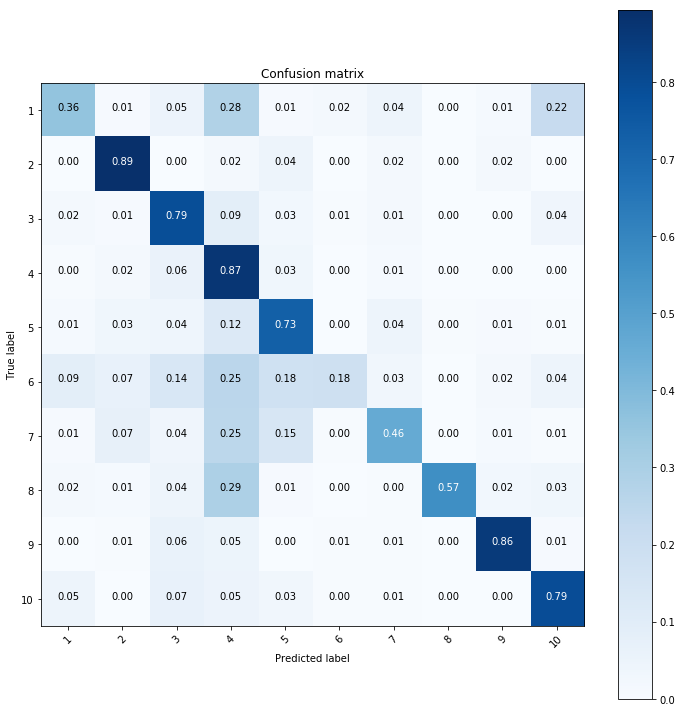

In [14]:
import matplotlib.pyplot as plt

#from sklearn.metrics import confusion_matrix

with torch.no_grad():
    train_preds, real_targets = get_all_preds(model, test_generator)

cm = confusion_matrix(real_targets.argmax(dim=1), train_preds.argmax(dim=1))
plt.figure(figsize=(num_classes,num_classes))
classes = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
plot_confusion_matrix(cm, classes)
    

Plot accuracy throughout the day

/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Test accuracy: 65.7487250811312%


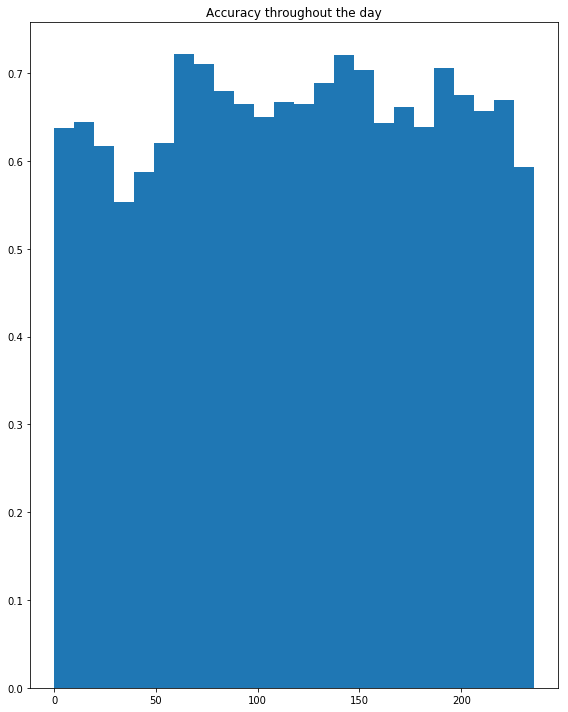

In [15]:
epoch_num = 12 # or 10
model = loadModel(model, model_name + "_" + str(epoch_num),"/media/kfir/wiseData/Project/Models/HPSS/epochs3/")
model.eval()
SoftM = torch.nn.Softmax()
Label_all = []
Output_all = []
timestamp_all = []
with torch.no_grad():                   # operations inside don't track history
    for dataBatch,label,timestamp in test_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
  
        output = model(dataBatch,timestamp)
        outP = torch.nn.functional.softmax(output)
        
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())
        timestamp_all.extend(timestamp.tolist())

array = (np.array(Label_all) == np.array(Output_all))
timestamp_all = np.array(timestamp_all)

plt.figure(figsize=(8, 10))
timestamp_false = timestamp_all[np.where(array==False)]
counts_false, bins_false = np.histogram(timestamp_false, bins=24)

timestamp_true = timestamp_all[np.where(array==True)]
counts_true, bins_true = np.histogram(timestamp_true, bins=24)
plt.subplot(1, 1, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.hist(bins_true[:-1], bins_true, weights=counts_true/(counts_true+counts_false))
plt.title('Accuracy throughout the day')
plt.tight_layout()


accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Test accuracy: {}%'.format(accuracy * 100))

Save model weights for ensemble

In [16]:
with torch.no_grad():
    train_preds, real_targets = get_all_preds(model, valid_generator)

cm = confusion_matrix(real_targets.argmax(dim=1), train_preds.argmax(dim=1))
cm = cm.type(torch.FloatTensor) / cm.sum(axis=1)[:, np.newaxis]
model_weights = torch.zeros(num_classes)
for i in range(0,num_classes):
    model_weights[i] = cm[i][i]
model_acc = torch.sum(model_weights) / num_classes

print("model accuracy is", model_acc)
print("model weights are ", model_weights)
torch.save(model_acc, "/media/kfir/wiseData/Project/Models/HPSS/accuracy.pt")
torch.save(model_weights, "/media/kfir/wiseData/Project/Models/HPSS/weights.pt")


/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


model accuracy is tensor(0.8725)
model weights are  tensor([0.7418, 0.9361, 0.9356, 0.9446, 0.9149, 0.7263, 0.8388, 0.8139, 0.9321,
        0.9412])
